##   Python加持: 猫眼众口一词，春节档的《流浪地球》，这267019人说了什么？！

2019年春节档，《流浪地球》横空出世，在强势口碑加持下，上映两周多票房即突破40亿！
与之相随的主题也霸占了春节期间的话题榜。
作为一部现象级的电影，笔者也很感兴趣，特意爬取了2月5日（初一）至2月12日（初八）
267019条猫眼影评，多角度可视化分析了《流浪地球》的数据规律。
接下来，跟我看看这267019人究竟说了什么吧！

### 数据分析准备工作
* 整个数据分析分为数据爬取、数据清洗、数据可视化和文本分析四个板块
* 项目采用Anaconda环境，过程仍需安装多个第三方模块
### 所需第三方模块（需提前安装）
* 数据可视化：pyecharts(是一个用于生成 Echarts 图表的类库).
* 文本分析：jieba(中文分词)，wordcloud(生成词云)等

### （一）数据爬取阶段

#### 1、工具库准备

In [ ]:
# 导入爬虫所需工具库
import time,random
import datetime as dt
import requests
import json

#### 2、user_agents准备

In [ ]:
# 8个备用user_agents
user_agents = [
            {'User-Agent': 'MQQBrowser/26 Mozilla/5.0 (Linux; U; Android 2.3.7; zh-cn; MB200 Build/GRJ22;\
            CyanogenMod-7) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'},
            {'User-Agent': 'Mozilla/5.0 (hp-tablet; Linux; hpwOS/3.0.0; U; en-US) AppleWebKit/534.6 \
            (KHTML, like Gecko) wOSBrowser/233.70 Safari/534.6 TouchPad/1.0'},
            {'User-Agent': 'Mozilla/5.0 (compatible; MSIE 9.0; Windows Phone OS 7.5;\
            Trident/5.0; IEMobile/9.0; HTC; Titan)'},
            {'User-Agent': 'Mozilla/5.0 (SymbianOS/9.4; Series60/5.0 NokiaN97-1/20.0.019;\
            Profile/MIDP-2.1 Configuration/CLDC-1.1) AppleWebKit/525 (KHTML, like Gecko) BrowserNG/7.1.18124'},
            {'User-Agent': 'Mozilla/5.0 (Linux; U; Android 3.0; en-us; Xoom Build/HRI39) \
            AppleWebKit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13'},
            {'User-Agent': 'Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3_3 like Mac OS X; en-us)\
            AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8J2 Safari/6533.18.5'},
            {'User-Agent': 'Mozilla/5.0 (iPad; U; CPU OS 4_3_3 like Mac OS X; en-us) \
            AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8J2 Safari/6533.18.5'},
            {'User-Agent': 'Mozilla/5.0 (Linux; U; Android 2.3.7; en-us; Nexus One Build/FRF91)\
            AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'},
            ]

#### 3、爬虫代码封装

In [ ]:
# 创建爬虫类
class MovieSpider(object):
    def __init__(self, filename):
        self.headers = user_agents
        self.filename = filename
        
    def get_data(self, header, url):
        '''
        功能：访问url的网址，获取网页内容并返回
        参数：url,目标网页的url
        返回：目标网页的html内容
        '''
        try:
            r = requests.get(url, headers=header)
            r.raise_for_status()
            return r.text
        except Exception as e:
            print(e)
    
    def parse_data(self, html):
        '''
        功能：提取 html 页面信息中的关键信息，并整合一个数组并返回
        参数：html 根据 url 获取到的网页内容
        返回：存储有 html 中提取出的关键信息的数组
        '''
        json_data = json.loads(html)['cmts']
        comments = []
        
        try:
            for item in json_data:
                comment = []
                # 提取影评中的6条数据：nickName(昵称),cityName(城市),content(评语)，
                # score(评分),startTime(评价时间),gender(性别)
                comment.append(item['nickName'])
                comment.append(item['cityName'] if 'cityName' in item else '')
                comment.append(item['content'].strip().replace('\n', ''))
                comment.append(item['score'])
                comment.append(item['startTime'])
                comment.append(item['gender']  if 'gender' in item else '')
                
                comments.append(comment)

            return comments
        
        except Exception as e:
            print(comment)
            print(e)
    
    def save_data(self, comments):
        '''
        功能：将comments中的信息输出到文件中/或数据库中。
        参数：comments 将要保存的数据
        '''
        df = pd.DataFrame(comments)
        df.to_csv(self.filename, mode='a', encoding='utf_8_sig',
                  index=False, sep=',', header=False)
    
    def run(self, time_lists):
        '''
        功能：爬虫调度器，根据规则每次生成一个新的请求 url，爬取其内容，并保存到本地。
        '''
#         start_time = dt.datetime.now().strftime('%Y-%m-%d  %H:%M:%S')
        start_time = time_lists[0]  # 电影上映时间，评论爬取到此截至
        end_time = time_lists[-1]  # 电影上映时间，评论爬取到此截至
        print('*******************')
        
        # 抓取评论信息
        i = 0
        while start_time > end_time:
            i += 1
            if i%10 ==0:
                print('已爬取%s页评论'%i)
            url = 'http://m.maoyan.com/mmdb/comments/movie/248906.json?_v_=\
            yes&offset=0&startTime=' + start_time.replace('  ', '%20')
            header = random.choice(self.headers)
            time.sleep(0.05)
            html = None
            
            try:
                html = self.get_data(header, url)
            except Exception as e:
                print('*************************')
                time.sleep(0.83)
                html = self.get_data(url)
                print(e)

            else:
                time.sleep(0.3)

            # 解析评论信息
            comments = self.parse_data(html)
            start_time = comments[14][4]

            start_time = dt.datetime.strptime(
                start_time, '%Y-%m-%d  %H:%M:%S') + dt.timedelta(seconds=-1)
            start_time = dt.datetime.strftime(start_time, '%Y-%m-%d  %H:%M:%S')

            self.save_data(comments)

#### 4、爬虫类执行

In [ ]:
# 通过改变时间点，选择爬取信息所处的时间段
t1 = ['2019-02-12  18:59:59','2019-02-12  00:00:00']
time_lists = t1
filename = '流浪地球%s_comments.csv'%time_lists[1].split()[0]
spider = MovieSpider(filename)
spider.run(time_lists)
print('爬取信息结束')

#### 5、爬虫过程项目总结
* 1、爬取2019-02-05日——2019-02-12日，8天共267019条评价数据。
* 2、实际爬取过程中会因为网站的反扒机制多次中断，导致部分数据丢失。

### （二）数据清洗阶段
* 1、此阶段主要依靠pandas对原始数据进行预处理
* 2、爬虫阶段得到的数据分布在多个csv文件中需要进行合并
* 3、数据中存在空值，根据需求进行删除或补充操作

#### 1、导入数据清洗所需工具库

In [1]:
import pandas as pd
import glob  # 在csv文件合并中读取所有的csv文件

#### 2、将爬取的多个csv文件进行合并

In [2]:
# 读取爬取的所有csv文件
csv_files = glob.glob('./*.csv')

# 将csv文件进行合并
for file in csv_files:
    data = pd.read_csv(file, names=['昵称','城市','评语','评分','日期','性别标签'],
                       encoding='utf_8_sig',engine='python',header=None)
    data.to_csv('合并文件/流浪地球01_comments.csv', mode='a', 
                encoding='utf_8_sig', index=False, sep=',')

#### 3、数据基本信息特征

In [3]:
# 读取合并后的文件信息
datas = pd.read_csv('合并文件/流浪地球01_comments.csv',
                encoding='utf_8_sig',engine='python')
# 查看数据的基本信息属性
datas.describe()

,昵称,城市,评语,评分,日期,性别标签
count,267014,266354,266994,266974,266968,141429
unique,239386,1061,247327,12,190455,3
top,.,北京,好看好看好看,5.0,2019-02-07 00:00:00,1.0
freq,379,8615,972,188289,16,89518


#### 4、所需的目标数据的预处理
* 提取数据基本特征可知：
* 费性别特征值均存在空值，但占比都很小；
* 为简化计算可分别将空值做删除处理

In [4]:
# 1、处理城市数据
# 统计各城市出现的数据信息
ct_datas = pd.DataFrame(datas['城市'])
# 将城市名称为空的数据删除
ct_datas = ct_datas.dropna(axis=0)
print(ct_datas.size)

# 2、处理评分数据
# pandas读取会员的评分数据
df_score =  pd.DataFrame(datas['评分'])
# 将评分为空的数据删除
df_score = df_score.dropna(axis=0)
print(df_score.size)

# 3、处理评语数据
# 读取会员的评语数据
dt_coms = pd.DataFrame(datas['评语'])
# 将评语为空的数据删除
dt_coms = dt_coms.dropna(axis=0)
print(dt_coms.size)
# 将评语保存为txt文档
dt_coms.to_csv("流浪地球_影评.txt",
               sep='\t', index=False)

266354
266974
266994


#### 5、数据清洗小结
* 主要根据数据分析的业务需求进行初步的数据处理
* 更加细致的数据处理在业务分析阶段实现

### （三）数据分布可视化
* 利用pyecharts可视化参与影评的粉丝分布情况
* 分别通过Geo和Bar函数进行数据可视化

#### 1、指明文件编码格式，识别中文字符

In [6]:
# 导入相关工具库
import importlib
import sys
importlib.reload(sys)

#### 2、城市分布信息处理
* 为实现Geo可视化全国粉丝分布，对ct_datas进行处理
* 定义数据格式处理的相关函数

In [7]:
# 城市信息列表化
# 将读取的城市特征信息转化为列表
def list_cities(ct_datas):
    # 统计每个城市的评论人数
    city_lists = []
    for city in ct_datas:
        if city:
            city_lists.append(city) 
        else:
            continue
    return city_lists

# 城市列表字典化，将城市列表转化为键为城市值为人数的字典
def set_list_cities(city_lists):
    # 统计城市的数量，添加到字典中
    city_sets = {}
    for city in city_lists:
        if city not in city_sets:
            city_sets[city] = 1
        city_sets[city] += 1
    return city_sets

# Geo格式化,将城市字典转化为Geo所需的数据格式
# 将城市信息和评论数量以元组格式添加到列表中
def geo_city_infos(city_sets):
    city_infos = []
    for city in city_sets:
        if city:
            ct = tuple((city, city_sets[city]))
            city_infos.append(ct)
    return city_infos


# 将Geo格式化的列表重新转化为字典格式
def set_info_cities(city_infos):
    # 统计城市的数量，添加到字典中
    city_sets = {}
    for city in city_infos:
        city_sets[city[0]] = city[1]
    return city_sets

In [9]:
# 生成城市列表
city_lists = list_cities(ct_datas['城市'])
print(len(city_lists))

# 生成城市数据字典
city_sets = set_list_cities(city_lists)
print(len(city_sets))

# 生成格式化城市数据
city_infos = geo_city_infos(city_sets)
print(len(city_infos))
data = city_infos

266354
1061
1061


#### 3、Geo可视化粉丝分布图
* pyecharts源代码的数据库中无法识别所有的城市，因此不能识别的城市需要特殊处理。
* 方法一是将所有不能识别的城市数据删除；
* 方法二是在源代码城市数据库中添加新城市的经纬度值。
#### 考虑到操作的简便性，此处采用方法一，将不能识别的城市数据删除

In [10]:
# Geo绘图函数
def geo_picture(data, city_sets):
    # 导入相关工具库
    # 导入Geo模块进行城市数据分析
    from pyecharts import Geo
    
    useless_cities = []
    city_infos = []
    for i in range(len(data)):
        geo = Geo("《流浪地球》全国观影粉丝分布图", "data from Maoyan", 
                  title_color="#fff",title_pos="center", width=1000,
                  height=750, background_color='#404a59')
        attr, value = geo.cast(data)

        try:
            geo.add("", attr, value, visual_range=[0, 200], maptype='china',type="effectScatter",
                    visual_text_color="#fff",symbol_size=10, is_visualmap=True)
        except Exception as e:
    #         print(e)
            # 在异常信息中提取无法被pyecharts识别的城市
            city = str(e).split()[-1]
            # 将不能识别的城市名称收集到列表中
            useless_cities.append(city)
            # 剔除无法识别的城市信息
            city_sets.pop(city)
            city_infos = geo_city_infos(city_sets)
            data = city_infos
    #生成html文件
    geo.render("全国观影粉丝分布图.html")
    return geo,city_infos,useless_cities


# 处理不能识别的城市名称，重新参与画图
def handle_cities(filename, city_sets):
    # 读取未识别的城市名称
    ul_cities = []
    with open(filename,'r',encoding='utf_8') as f:
        ul_lists = f.readlines()
        
    # 删除非中文格式的城市
    for city in ul_lists:
        ch = city.strip()[0]
        if u'\u4e00' <= ch <= u'\u9ffff':
            ul_cities.append(city.strip())
    print(len(ul_cities))
    
    # 判断是否由于下面集合中的字的缺失或是多余导致
    ad_re_cities = []
    cityname = ''
    lists = ['县','区','市','州']
    for city in ul_cities:
        if city[-1] not in lists:
            for j in lists:
                cityname = city+j
                ad_re_cities.append((cityname,city_sets[city]))
        elif len(city)>=3:
            cityname = ''.join(city[:-1])
            ad_re_cities.append((cityname, city_sets[city]))
        else:
            continue
    return ad_re_cities


# 存储不能识别的城市信息
def store_cities(useless_cities,filename):
    ul_cities = pd.DataFrame(useless_cities)
    ul_cities.to_csv(filename,sep='\t', index=False)

In [12]:
# 运行Geo模块
pre_city_sets = set_list_cities(city_lists)
print(len(pre_city_sets))
geo,city_infos,useless_cities = geo_picture(data, pre_city_sets)

# 定义存储不能识别城市的文件名称
filename = '未识别城市.txt'

# 存储城市信息
store_cities(useless_cities,filename)

1061


In [13]:
# 生成处理后的新城市信息
print(len(city_sets))
ad_re_cities = handle_cities(filename, city_sets)
print(len(ad_re_cities))

1061
371
1389


In [14]:
# 处理后的城市与已识别的城市信息合并
final_city_infos = ad_re_cities + city_infos
cur_city_sets = set_info_cities(final_city_infos)
# print(next_city_sets)

# 重新运行Geo模块
geo,_,_ = geo_picture(final_city_infos,cur_city_sets)

# 绘制全国观影粉丝分布图
# 直接在notebook中显示
geo

#### Geo可视化粉丝分布小结
* pyecharts识别城市能力有限，导致380个左右的城市信息无法识别
* 总体上来说主要城市信息是能正常识别的，因此不会对头部信息有较大影响
* 对于定型化了解全国影迷分布仍具有很大的参考价值
#### 具体分布信息见上图
* 1、中东部是《流浪地球》影迷和影评的主力；
* 2、广大的西部地区影评人数严重不足；
* 3、影评的密度与地区人口的分布密度正相关。

#### 4、利用Bar可视化评论头部城市信息
* 利用pyecharts中的Bar模块进行分析
* 查看影评数量在前20名的城市信息
* 利用pyecharts中的Style模块定义可视化图形

In [15]:
from pyecharts import Bar
from pyecharts import Style


# 定义样式
style = Style(
    title_color='#fff',
    title_pos='center',
    width=1000,
    height=600,
    background_color='#404a59',
    subtitle_color='#fff'
)

# 根据城市数据生成柱状图
city_counts = ct_datas.groupby("城市").size()
city_sorted = city_counts.sort_values(ascending=False).head(20)

bar = Bar("《流浪地球》评星人来源排行TOP20", "蜗牛行天下", **style.init_style)
attr, value = bar.cast(list(city_sorted.items()))
bar.add("", attr, value, is_visualmap=True, visual_range=[0, 2500],
        visual_text_color='#fff', label_color='#fff',
        xaxis_label_textcolor='#fff', yaxis_label_textcolor='#fff', 
        is_more_utils=True,is_label_show=True)

# 保存可视化图片文件
bar.render("评星人来源排行-柱状图.html")
# 图像可视化
bar

#### Bar可视化分析小结
* 从上图可见，城市粉丝评论数量顺序与城市的经济实力排名相吻合。
* 此外，城市粉丝评论数量顺序也与城市人口数量排名正相关。
* 由此可以初步推断，城市经济实力越强。人口越多，市民的观影数量越多，娱乐生活越丰富。

#### 5、Pie模块可视化《流浪地球》的星级评价&区分性别
* 利用pyecharts的Pie模块分析《流浪地球》的评分分布
* 将评分进行分段处理，用一星到五星来标定影片评价等级
* 分别考察不同性别影迷对《流浪地球》的评分结果，探究性别影响。
* 性别缺失值较多，但因为数据是否缺失没有明显的性别差异，缺失值可以删除

In [18]:
# 构建Pie图生成函数
def genPiePicture(df_score):
# 导入Pie组件，用于生成饼图
    from pyecharts import Pie


    # 设定五个等级的星级标签
    attr = ["一星", "二星", "三星", "四星", "五星"]
    score = df_score.groupby("评分").size()  # 分组求和
    # print(score)

    value = [
        score.iloc[0] + score.iloc[1] + score.iloc[2], # 0,0.5,1分均定为一星
        score.iloc[3] + score.iloc[4],  # 1.5，2分均定位二星
        score.iloc[5] + score.iloc[6],  # 2.5,3分均定为三星
        score.iloc[7] + score.iloc[8],  # 3.5,4分均定为四星
        score.iloc[9] + score.iloc[10], # 4.5，5分均定为五星
    ]
    
    # 利用Pie模块，数据可视化
    pie = Pie('《流浪地球》评星比例', title_pos='left', width=1000, height=500)
    pie.use_theme("dark")
    pie.add("评分", attr, value, center=[60, 60], radius=[25, 75], 
            rosetype='raea', is_legend_show=True, is_label_show=True)
    pie.render('评星.html')
    return pie

#### 分性别处理影评数据

In [32]:
# 处理性别数据
# 1、删除缺失值
gender_datas = datas.dropna(subset=['性别标签'])
print(len(gender_datas))

# 2、分别读取男女性别数据，男gender值为'1.0'，女为'2.0'
male_datas = gender_datas[gender_datas.性别标签=='1.0']
female_datas = gender_datas[gender_datas.性别标签=='2.0']

# 3、分别读取男女会员的评分数据
male_score =  pd.DataFrame(male_datas['评分'])
female_score =  pd.DataFrame(female_datas['评分'])

141429


In [33]:
# 生成男性的评分pie图
male_pie = genPiePicture(male_score)
male_pie

In [34]:
# 生成女性的评分pie图
female_pie = genPiePicture(female_score)
female_pie

#### 《流浪地球》星级评价小结
* 男女影评者均有85%左右的比例对《流浪地球》给出了5星的评价。
* 男女影评者具有超过93%的影评者对《流浪地球》给出了超过4星的评价。
* 《流浪地球》是一部基本没有性别区分度的影片，男女通吃。
* 《流浪地球》是一部评价很高（评分数据超过大多数影片），值得一看。

### （四）评语文本分析
* 利用jieba分词工具包对评语进行分词处理，分析评语文本信息。
* 对所得的评语分词进行头部分析，利用wordcloud生成词云，可视化评语。
* 原始评语过于庞大(700万字），此处不做详细分析。
* 更为详细的文本分析见‘《流浪地球》猫眼评语文本分析’一文。

#### 1、导入文本分析工具包

In [35]:
import jieba
import matplotlib.pyplot as mp
from wordcloud import STOPWORDS, WordCloud
from os import path
from PIL import Image
import numpy as np

#### 2、获取样本评语数据
* 为简化分析，随机选择了一个小样本（1.6万字左右）进行简要分析。

In [36]:
# 获取所有的评论
comments = []

with open("流浪地球_影评01.txt", 'r', encoding='utf-8') as f:
    rows = f.readlines()
    for row in rows:
        try:
            comment = row.strip().split(',')
        except IndexError:
            continue
        if comment:
            comments.append(comment)
print(len(comments))

524


In [37]:
# 设置分词
com_aft_spl = jieba.cut(
    str(comments),cut_all=False) # 非全模式分词，cut_all=False
words = ' '.join(com_aft_spl)
print(len(words))

# 设置停用词,在默认停用词基础上添加新的停用词
stopwords = STOPWORDS.copy()
wd_libs = ['电影','一部','一个','没有','什么','有点','这部','这个','不是','我们',
          '真的','感觉','觉得','还是','但是','就是','流浪地球','流浪','地球','中国']
for wl in wd_libs:
    stopwords.add(wl)
print(len(stopwords))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Python\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\Python\AppData\Local\Temp\jieba.cache
Loading model cost 1.126 seconds.
DEBUG:jieba:Loading model cost 1.126 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


32939
210


In [38]:
# 词云代码构建
d = path.dirname('__file__')
nana_coloring = np.array(Image.open(path.join(d, "car.png"))) # 词云形状由图片‘car.png’决定
my_wordcloud = WordCloud( background_color = 'white',      # 设置背景颜色
                            mask = nana_coloring,          # 设置背景图片
                            max_words = 200,              # 设置最大现实的字数
                            stopwords = stopwords,         # 设置停用词
                            font_path = 'simhei.ttf',
                            max_font_size = 100,            # 设置字体最大值
                            random_state = 30             # 设置有多少种随机生成状态，即有多少种配色方案
                          )
my_wordcloud.generate(words)

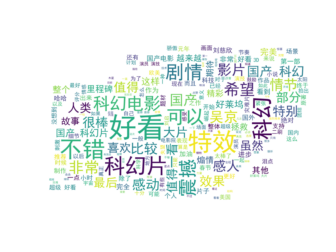

In [39]:
# 可视化词云图
mp.imshow(my_wordcloud,cmap=mp.cm.gray, interpolation='bilinear')    # 显示词云图
mp.axis("off")             # 不显示x轴、y轴下标
mp.show()
my_wordcloud.to_file("wordcloud_new.png")

#### 评语文本分析小结
* 文本可视化看到影迷的主评价词为：好看，科幻，震撼，特效剧情。
* 从影评评价中可以看出《流浪地球》的口碑非常不错，值得一看！